In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

import tensorflow as tf

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks

import joblib

In [2]:
import math
from typing import Optional, Union, Tuple

In [3]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jena-climate-2009-2016/jena_climate_2009_2016.csv


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


## Helper Functions

In [5]:
def create_sliding_window(features: np.ndarray, target: np.ndarray, window_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Creates sliding windows for the given data to provide context for LSTM Prediction.

    Args:
        features (np.ndarray): Input feature values.
        target (np.ndarray): Target values.
        window_size (int): Size of the sliding window.

    Retruns:
        Tuple[np.ndarray, np.ndarray]
    """

    X, y = [], []
    total_length = len(features)

    for i in range(total_length - window_size):
        X.append(features[i:i+window_size])
        y.append(target[i + window_size])

    return (np.array(X), np.array(y))

In [ ]:
def prepare_train_test_datasets(
    df: pd.DataFrame,
    test_split: Optional[float],
    window_size: int,
    feature_scaler: Optional[StandardScaler] = None,
    target_scaler: Optional[StandardScaler] = None
) -> Union[
    Tuple[int, np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler, StandardScaler],
    Tuple[np.ndarray, np.ndarray]
]:
    """
    Prepare the training and validation datasets. Or prepare the test dataset.
    Depends upon the test_split parameter.

    Args:
        df (pd.DataFrame): Input dataframe.
        test_split (float, optional): Fraction of data used for validation. If None, treats input as test data.
        window_size (int): Size of the sliding window.
        feature_scaler (StandardScaler, optional): Pre-fitted feature scaler (for test).
        target_scaler (StandardScaler, optional): Pre-fitted target scaler (for test).

    Returns:
        Union[
            Tuple[int, np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler, StandardScaler],
            Tuple[np.ndarray, np.ndarray]
        ]

        if test_split is None: Returns training_data_len, X_train, y_train, X_val, y_val, feature_scaler, target_scaler
        else: Returns X_test, y_test
    """
    
    features = df.drop(columns=['T (degC)']).values
    target = df['T (degC)'].values.reshape(-1, 1)

    if test_split is not None:
        training_data_len = int(np.ceil((1 - test_split) * len(features)))

        # Initialize Scaler and Fit Transform entire dataset
        feature_scaler = StandardScaler()
        target_scaler = StandardScaler()

        scaled_features = feature_scaler.fit_transform(features)
        scaled_target = target_scaler.fit_transform(target)

        scaled_features_train = scaled_features[:training_data_len]
        scaled_target_train = scaled_target[:training_data_len]

        X_train, y_train = create_sliding_window(scaled_features_train, scaled_target_train, window_size)

        scaled_features_val = scaled_features[training_data_len - window_size:]
        scaled_target_val = scaled_target[training_data_len - window_size:]

        X_val, y_val = create_sliding_window(scaled_features_val, scaled_target_val, window_size)

        return training_data_len, X_train, y_train, X_val, y_val, feature_scaler, target_scaler

    else:
        assert feature_scaler is not None and target_scaler is not None, "Scalers must be provided when test_split is None"

        scaled_features_test = feature_scaler.transform(features)
        scaled_target_test = target_scaler.transform(target)

        X_test, y_test = create_sliding_window(scaled_features_test, scaled_target_test, window_size)

        return X_test, y_test

In [7]:
def build_model(X_train: np.ndarray, learning_rate: float) -> keras.Model:
    """
    Builds and compiles the Deep Learning model.

    Args:
        X_train (np.ndarray): Training data.
        learning_rate (float): Learning Rate for the optimizer.

    Retruns:
        keras.Model: Compiled Keras model.
    """

    model = models.Sequential(name="ImprovedTempPredictor")
    
    model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
    model.add(layers.BatchNormalization())

    model.add(layers.Bidirectional(layers.LSTM(32)))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1))

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='mae',
        metrics=['root_mean_squared_error', 'r2_score']
    )
    
    model.summary()
    
    return model

## Import Dataset

In [8]:
df = pd.read_csv("/kaggle/input/jena-climate-2009-2016/jena_climate_2009_2016.csv")
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [9]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


## Clean Dataset

In [10]:
cleaned_df = df.copy()

# Add engineered time features
cleaned_df['Month'] = date_time.dt.month
cleaned_df['Week'] = date_time.dt.isocalendar().week
cleaned_df['Year'] = date_time.dt.year
 
cleaned_df.dropna(inplace=True)

In [11]:
cleaned_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),Month,Week,Year
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7,1,1,2009
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3,1,1,2009
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2,1,1,2009
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0,1,1,2009
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0,1,1,2009


#### A very clean periodic trend can be noticed with temperature, relative humidity along the years.

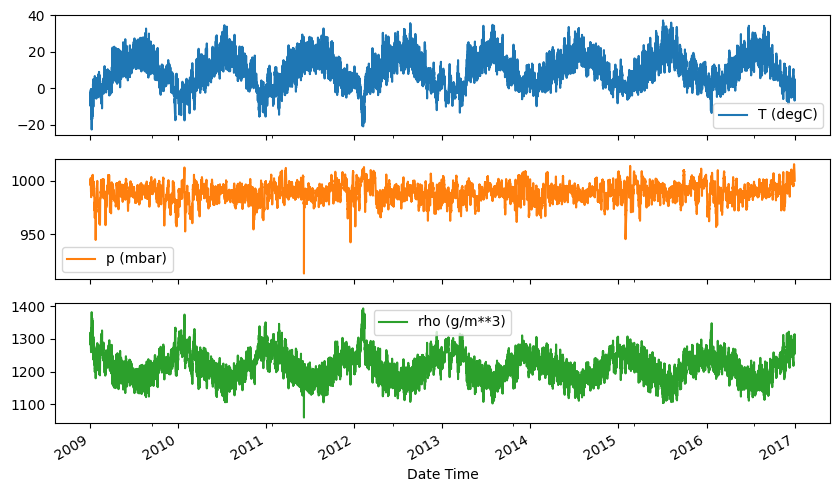

In [12]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = cleaned_df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize=(10,6))

## Feature Engineering

In [13]:
cleaned_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.6,984.2,989.57,994.72,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.48,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.53,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.8,0.24,5.21,10.08,23.06
rh (%),70091.0,76.009788,16.47492,13.88,65.21,79.3,89.4,100.0
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.61,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.36,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.0,0.87,2.19,5.3,46.01
sh (g/kg),70091.0,6.02256,2.655812,0.51,3.92,5.59,7.8,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.49,28.74


In [14]:
## Remove Outlier / Erroneous Values

cleaned_df.loc[-9999.0, 'wv (m/s)'] = 0.0
cleaned_df.loc[-9999.0, 'max. wv (m/s)'] = 0.0

#### Since Wind Direction is in degrees, convert them Wind Velocity and Max Wind Velocity columns to vectors

In [ ]:
wv = cleaned_df.pop('wv (m/s)')
max_wv = cleaned_df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = cleaned_df.pop('wd (deg)') * np.pi / 180

# Calculate the wind x and y components.
cleaned_df['Wx'] = wv * np.cos(wd_rad)
cleaned_df['Wy'] = wv * np.sin(wd_rad)

# Calculate the max wind x and y components.
cleaned_df['max Wx'] = max_wv * np.cos(wd_rad)
cleaned_df['max Wy'] = max_wv * np.sin(wd_rad)

In [16]:
cleaned_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Month,Week,Year,Wx,Wy,max Wx,max Wy
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,1.0,1,2009.0,-0.204862,-0.046168,-0.614587,-0.138503
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,1.0,1,2009.0,-0.245971,-0.044701,-0.619848,-0.112645
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,1.0,1,2009.0,-0.175527,0.039879,-0.614344,0.139576
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,1.0,1,2009.0,-0.050000,-0.086603,-0.190000,-0.329090
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,1.0,1,2009.0,-0.368202,0.156292,-0.810044,0.343843


#### Both DayOfYear (1–365) and Hour (0–23) are cyclical.

#### Neural nets don’t naturally understand that 23:00 and 00:00 are close in time.

#### By encoding them as sine/cosine vectors, you map them onto a circle — preserving cyclic proximity.

In [17]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

cleaned_df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
cleaned_df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
cleaned_df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
cleaned_df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [18]:
cleaned_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,Week,Year,Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,...,1,2009.0,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,...,1,2009.0,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,...,1,2009.0,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,...,1,2009.0,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,...,1,2009.0,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


Text(0.5, 1.0, 'Time of day signal')

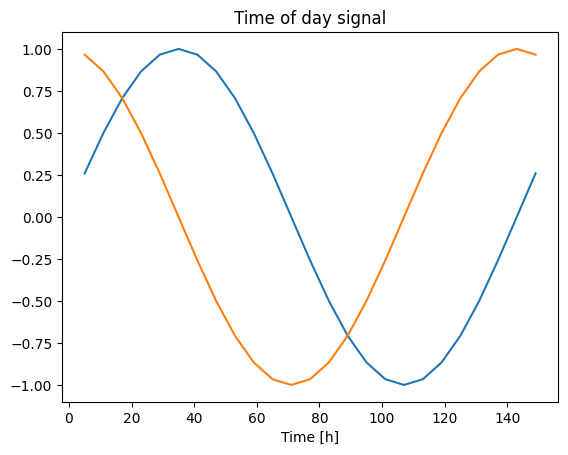

In [19]:
plt.plot(cleaned_df['Day sin'][:25])
plt.plot(cleaned_df['Day cos'][:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [20]:
# Drop rows with missing values

cleaned_df.dropna(inplace=True)
cleaned_df.isna().sum()

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
Month              0
Week               0
Year               0
Wx                 0
Wy                 0
max Wx             0
max Wy             0
Day sin            0
Day cos            0
Year sin           0
Year cos           0
dtype: int64

## Model Training

### Create Train and Validation Datasets

In [21]:
n = len(df)

train_and_val_df = cleaned_df[0:int(n*0.9)]

In [22]:
training_data_len, X_train, y_train, X_val, y_val, feature_scaler, target_scaler = prepare_train_test_datasets(train_and_val_df, 0.2, 24)

In [23]:
# Hyperparameters
batch_size = 128
epochs = 100
learning_rate = 0.001

# Build model
model = build_model(X_train, learning_rate)

# Early stopping to avoid overfitting
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate to avoid overshooting and plateuing
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Fit model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

I0000 00:00:1747988602.306201      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747988602.306922      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "ImprovedTempPredictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 24, 64)              │           4,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 24, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 24, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,609 (455.50 KB)

 Trainable params: 116,097 (453.50 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/100


I0000 00:00:1747988612.155731     132 cuda_dnn.cc:529] Loaded cuDNN version 90300


395/395 - 18s - 45ms/step - loss: 0.2700 - r2_score: 0.8602 - root_mean_squared_error: 0.3817 - val_loss: 0.1519 - val_r2_score: 0.9529 - val_root_mean_squared_error: 0.1970 - learning_rate: 0.0010
Epoch 2/100
395/395 - 6s - 16ms/step - loss: 0.1687 - r2_score: 0.9525 - root_mean_squared_error: 0.2224 - val_loss: 0.0989 - val_r2_score: 0.9797 - val_root_mean_squared_error: 0.1293 - learning_rate: 0.0010
Epoch 3/100
395/395 - 6s - 15ms/step - loss: 0.1516 - r2_score: 0.9613 - root_mean_squared_error: 0.2007 - val_loss: 0.1101 - val_r2_score: 0.9767 - val_root_mean_squared_error: 0.1387 - learning_rate: 0.0010
Epoch 4/100
395/395 - 6s - 16ms/step - loss: 0.1449 - r2_score: 0.9639 - root_mean_squared_error: 0.1940 - val_loss: 0.1062 - val_r2_score: 0.9778 - val_root_mean_squared_error: 0.1352 - learning_rate: 0.0010
Epoch 5/100
395/395 - 6s - 15ms/step - loss: 0.1410 - r2_score: 0.9658 - root_mean_squared_error: 0.1888 - val_loss: 0.0759 - val_r2_score: 0.9871 - val_root_mean_squared_erro

## Training History and Prediction Graphs

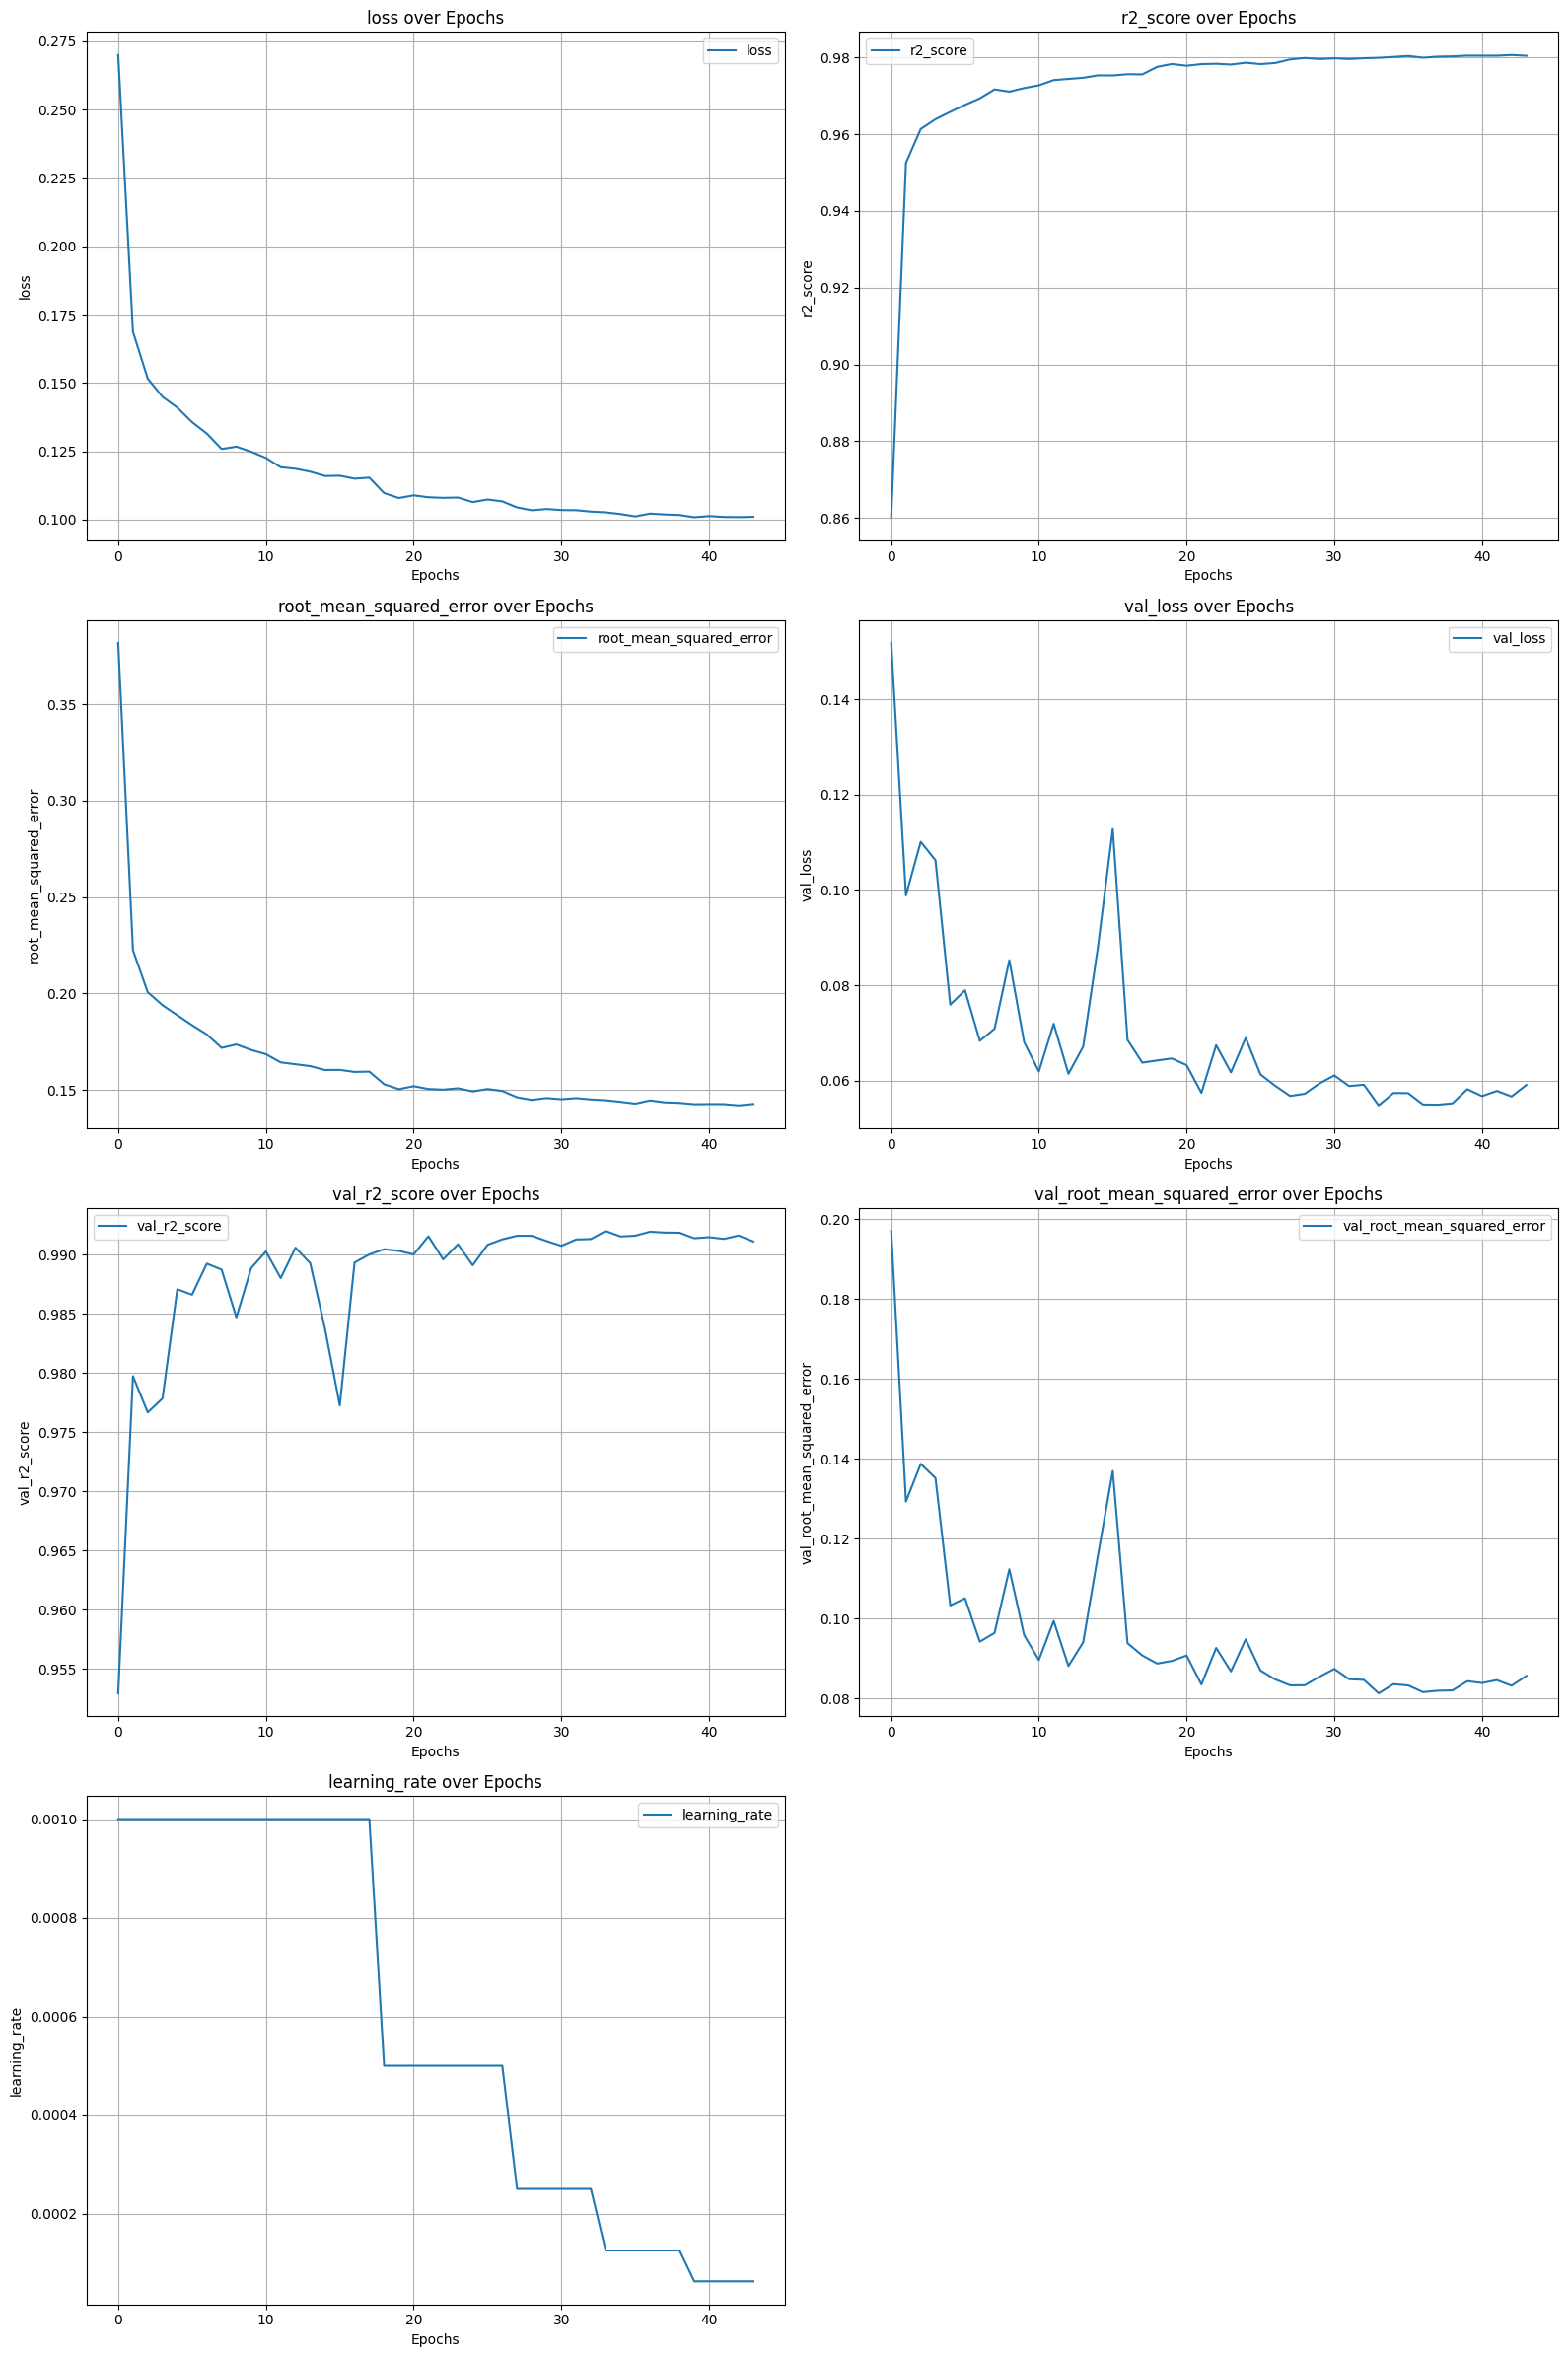

In [24]:
def generate_history_graph(history: dict) -> None:
    """
        Plots History Graph.

        Args:
            history (dict): History Dictionary from Keras model training.

        Returns:
            None
    """

    metrics = list(history.history.keys())
    num_metrics = len(metrics)
    cols = 2
    rows = math.ceil(num_metrics / cols)

    plt.figure(figsize=(8 * cols, 6 * rows))

    for idx, metric in enumerate(metrics, 1):
        plt.subplot(rows, cols, idx)
        plt.plot(history.history[metric], label=metric)
        plt.title(f"{metric} over Epochs")
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

generate_history_graph(history)

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


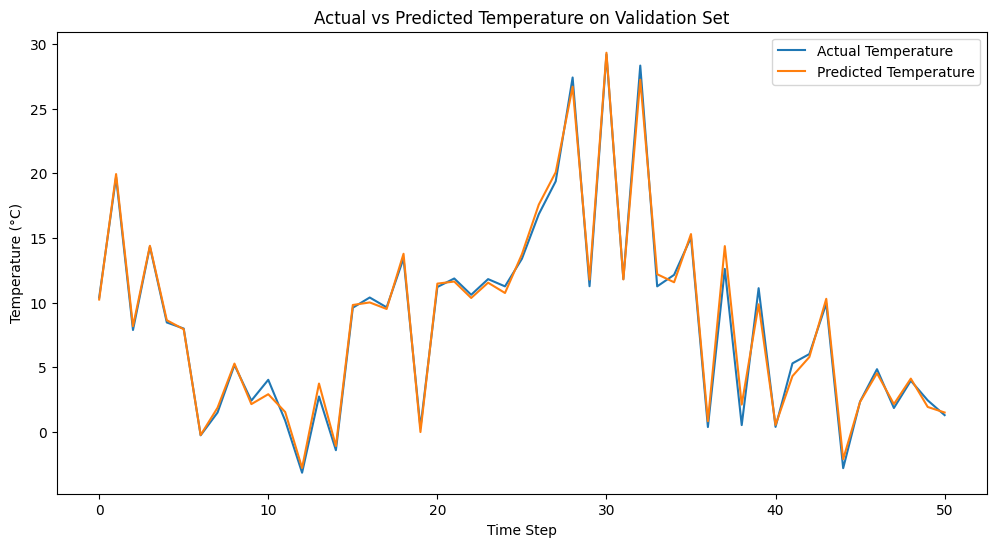

In [25]:
def generate_prediction_graph(
    X: np.ndarray, 
    y: np.ndarray, 
    target_scaler: StandardScaler, 
    is_test=False
) -> Optional[Tuple[np.ndarray, np.ndarray]]:
    """
        Plots Prediction Graph on the Validation/Test Dataset.
        Depends upon the is_test parameter.

        Args:
            X & y (np.ndarray): Input features and target.
            target_scaler (StandardScaler): Scaler to inverse transform predictions.
            is_test (bool): If True, indicates test dataset.

        Returns:
            Optional[Tuple[np.ndarray, np.ndarray]]

            if is_test is True: Returns y_true and y_pred for model metrics
    """

    y_pred_scaled = model.predict(X)

    # 2. Inverse scale to original units
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    y_true = target_scaler.inverse_transform(y)
    
    # 3. Plot first 100 samples or full range
    plt.figure(figsize=(12,6))
    plt.plot(y_true[::250], label='Actual Temperature')
    plt.plot(y_pred[::250], label='Predicted Temperature')
    plt.xlabel('Time Step')
    plt.ylabel('Temperature (°C)')
    plt.title(f"Actual vs Predicted Temperature on {'Test' if is_test else 'Validation'} Set")
    plt.legend()
    plt.show()

    if is_test:
        return y_true, y_pred


generate_prediction_graph(X_val, y_val, target_scaler)

218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


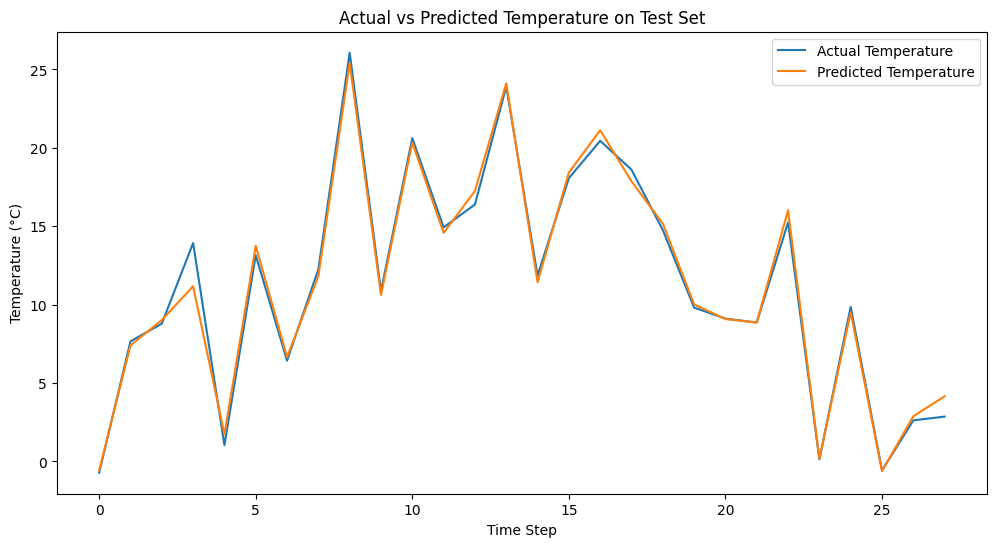

In [26]:
test_df = cleaned_df[int(n*0.9):]

X_test, y_test = prepare_train_test_datasets(test_df, None, 60, feature_scaler, target_scaler)

y_true, y_pred = generate_prediction_graph(X_test, y_test, target_scaler, True)

In [27]:
y_pred_rounded = np.round(y_pred, 2)

comparison_array = np.concatenate([y_true[::20], y_pred_rounded[::20]], axis=1)
comparison_df = pd.DataFrame(comparison_array, columns=['Actual_Temperature', 'Predicted_Temperature'])

In [28]:
comparison_df.head()

,Actual_Temperature,Predicted_Temperature
0,-0.72,-0.58
1,0.32,-0.05
2,2.15,2.00
3,5.72,5.44
4,11.00,10.85


## Metrics

In [29]:
mae = mean_absolute_error(y_true, y_pred_rounded)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_rounded))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.4794
RMSE: 0.6840


In [30]:
r2 = r2_score(y_true, y_pred_rounded)
print(f"R^2 score: {r2:.4f}")

R^2 score: 0.9923


## Save Model and Scalers

In [ ]:
model.save('TempPredictor.keras')
joblib.dump(feature_scaler, 'FeatureScaler.joblib')
joblib.dump(target_scaler, 'TargetScaler.joblib')

['TargetScaler.joblib']